In [7]:
# !pip install airfrans
import airfrans as af
data_path = './airfrans_dataset'

In [10]:
# af.dataset.download(root = data_path, unzip = True)

In [66]:
name = 'airFoil2D_SST_31.382_3.588_1.994_6.206_0.0_13.271'
simulation = af.Simulation(root = data_path, name = name)

In [67]:
simulation.__dict__.keys()

dict_keys(['root', 'name', 'T', 'MOL', 'P_ref', 'RHO', 'NU', 'C', 'inlet_velocity', 'angle_of_attack', 'internal', 'airfoil', 'surface', 'sdf', 'input_velocity', 'position', 'airfoil_position', 'airfoil_normals', 'normals', 'velocity', 'pressure', 'nu_t'])

Number of airfoil points: 1018
Number of internal grid points: 180790
Number of quads: 179529


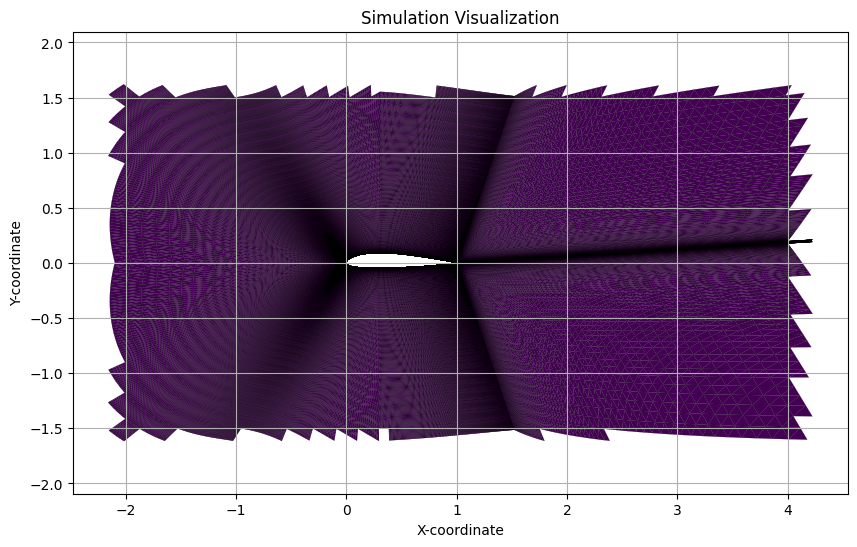

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyvista as pv
import numpy as np

def plot_airfoil(simulation, show=True, save_path=None):
    # Access the internal grid and airfoil data
    internal_grid = simulation.internal
    airfoil_data = simulation.airfoil

    # Extract coordinates for internal grid
    x_internal = internal_grid.points[:, 0]
    y_internal = internal_grid.points[:, 1]

    # Extract coordinates for airfoil
    x_airfoil = airfoil_data.points[:, 0]
    y_airfoil = airfoil_data.points[:, 1]
    print(f"Number of airfoil points: {len(x_airfoil)}")
    print(f"Number of internal grid points: {len(x_internal)}")

    # Check the cell type of the internal grid
    cell_type = internal_grid.celltypes[0]  # Get the cell type of the first cell

    
    # Create a triangulation based on the cell type
    if cell_type == pv.CellType.TRIANGLE:  # If cells are triangles
        triangles = internal_grid.cells.reshape(-1, 4)[:, 1:]  # Reshape for triangles
        triangulation = tri.Triangulation(x_internal, y_internal, triangles)
        # Create a 1D array of facecolors (e.g., all triangles the same color)
        facecolors = np.zeros(len(triangles))  
        print(f"Number of triangles: {len(triangles)}")
    elif cell_type == pv.CellType.QUAD:  # If cells are quadrilaterals
        
        quads = internal_grid.cells.reshape(-1, 5)[:, 1:]  # Reshape for quads
        # matplotlib.tri only supports triangles, so we need to triangulate the quads

        triangles = []
        for quad in quads:
            # Split each quadrilateral into two triangles
            # First triangle: vertices 0, 1, 2 of the quad
            # Second triangle: vertices 0, 2, 3 of the quad
            triangles.extend([[quad[0], quad[1], quad[2]], [quad[0], quad[2], quad[3]]])
        triangulation = tri.Triangulation(x_internal, y_internal, triangles)
        # Create a 1D array of facecolors (e.g., all triangles the same color)
        facecolors = np.zeros(len(quads)) # one color per quad
        # To color each triangle of a quad with the same color, we repeat color values
        facecolors = np.repeat(facecolors, 2)
        print(f"Number of quads: {len(quads)}")
    else:
        triangulation = None  # Handle other cell types or raise an error
    
    

    # Create the plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot internal grid
    if triangulation:
        # Use facecolors instead of triangulation.triangles for tripcolor
        plt.tripcolor(triangulation, 
                      facecolors=facecolors, 
                      cmap='viridis', 
                      edgecolors='k', 
                      linewidth=0.1
                      ) 
    else:
        plt.plot(x_internal, y_internal, 'k.', markersize=0)  # Adjust marker style and size as needed


    # Plot airfoil
    plt.plot(x_airfoil, y_airfoil, 'r-', linewidth=0)  # Adjust line style and width as needed
    
    # Customize the plot
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Simulation Visualization')
    plt.axis('equal')  # Ensure equal aspect ratio
    plt.grid(True)

    if show:
        plt.show()

    plt.close()

plot_airfoil(simulation, save_path='airfoil_plot.png')

In [5]:
simulation.airfoil

PolyData (0x169ea6e00)
  N Cells:    1018
  N Points:   1018
  N Strips:   0
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   -7.214e-02, 7.214e-02
  Z Bounds:   5.000e-01, 5.000e-01
  N Arrays:   10

In [6]:
simulation.internal


UnstructuredGrid (0x169ea6da0)
  N Cells:    179489
  N Points:   180750
  X Bounds:   -2.163e+00, 4.226e+00
  Y Bounds:   -1.614e+00, 1.615e+00
  Z Bounds:   5.000e-01, 5.000e-01
  N Arrays:   12

There is no LR and HR data in the dataset. We will have to downsample dataset for the LR. 

Extract the coordinates and the desired flow field (e.g., pressure 'p' or velocity 'U'). The .vtu files confirm 'p' and 'U' are available in PointData.

In [69]:
internal_grid = simulation.internal
x_internal = internal_grid.points[:, 0]
y_internal = internal_grid.points[:, 1]

internal_grid = simulation.internal
quads = internal_grid.cells.reshape(-1, 5)[:, 1:]  # Reshape for quads
# matplotlib.tri only supports triangles, so we need to triangulate the quads

triangles = []
for quad in quads:
    # Split each quadrilateral into two triangles
    # First triangle: vertices 0, 1, 2 of the quad
    # Second triangle: vertices 0, 2, 3 of the quad
    triangles.extend([[quad[0], quad[1], quad[2]], [quad[0], quad[2], quad[3]]])
triangulation = tri.Triangulation(x_internal, y_internal, triangles)

In [70]:
simulation.airfoil.points[:, 0]

pyvista_ndarray([0.29610524, 0.3041747 , 0.28823292, ..., 0.3281073 ,
                 0.32021415, 0.31223685], dtype=float32)

In [71]:
# plot the triangulation in gray scale image gradient 

# append airfoil data to the triangulation
x_airfoil = simulation.airfoil.points[:, 0]
y_airfoil = simulation.airfoil.points[:, 1]

min_x_airfoil, max_x_airfoil = min(x_airfoil), max(x_airfoil)
min_y_airfoil, max_y_airfoil = min(y_airfoil), max(y_airfoil)

# get the min and max area size of triangulation
areas = np.zeros(len(triangulation.triangles))
airfoil_mask = np.ones(len(triangulation.triangles))
# based the area size of the triangles color the triangles
for i, triangle in enumerate(triangulation.triangles):
    # Get the vertices of the triangle
    p1 = (triangulation.x[triangle[0]], triangulation.y[triangle[0]])
    p2 = (triangulation.x[triangle[1]], triangulation.y[triangle[1]])
    p3 = (triangulation.x[triangle[2]], triangulation.y[triangle[2]])
    
    # Calculate the area using the determinant method
    area = 0.5 * np.abs(p1[0] * (p2[1]-p3[1]) + p2[0] * (p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
    areas[i] = area

    # Check if any of the vertices are inside the airfoil
    inside = 0
    for x, y in [p1, p2, p3]:
      # Simple bounding box check (replace with more accurate point-in-airfoil check if needed)
      if min_x_airfoil <= x <= max_x_airfoil and min_y_airfoil <= y <= max_y_airfoil:
        inside = 1
        break
    airfoil_mask[i] = inside




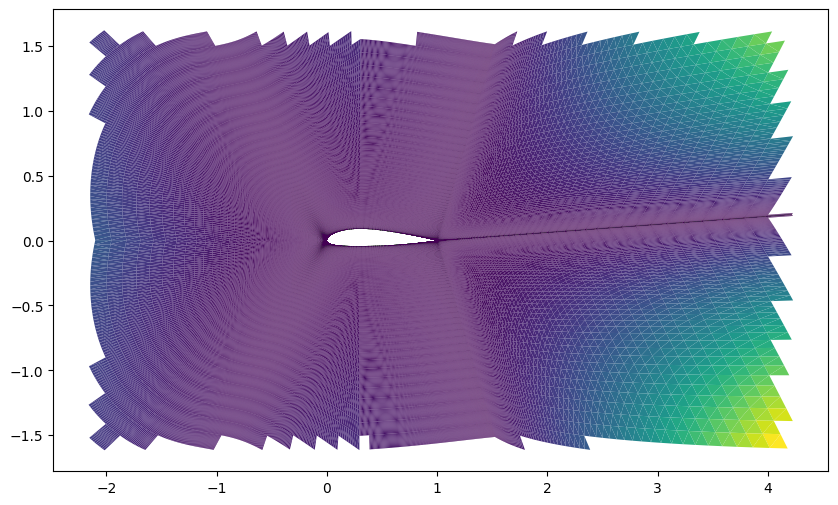

In [61]:
# plot airfoil_mask 
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.tripcolor(triangulation, 
              facecolors=areas, 
              edgecolors='k', 
              linewidth=0
              )
# plt.plot(x_airfoil, y_airfoil, 'r-', linewidth=0)  # Adjust line style and width as needed
plt.show()


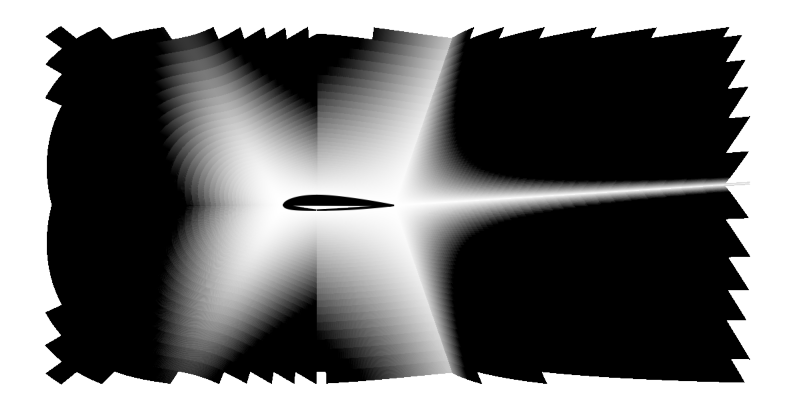

In [75]:
import io
from PIL import Image

def show_data(areas, airfoil_mask):
    # --- Process areas (same as before) ---
    areas = 1 - areas
    areas = (areas - areas.min()) / (areas.max() - areas.min())
    threshold  = 0.95
    areas[areas < threshold] = np.nan
    areas = (areas - np.nanmin(areas)) / (np.nanmax(areas) - np.nanmin(areas))
    areas = np.nan_to_num(areas, nan=0) # Background is black

    # --- Ensure airfoil polygon is closed ---
    # Use simulation.airfoil.points directly
    airfoil_points = simulation.airfoil.points[:, :2] # Get X, Y coordinates
    if not np.allclose(airfoil_points[0], airfoil_points[-1]):
        airfoil_closed_points = np.vstack((airfoil_points, airfoil_points[0]))
    else:
        airfoil_closed_points = airfoil_points

    x_airfoil_closed = airfoil_closed_points[:, 0]
    y_airfoil_closed = airfoil_closed_points[:, 1]

    # --- Create Figure and Axes using Object-Oriented approach ---
    fig, ax = plt.subplots(figsize=(10, 6), frameon=False) # frameon=False helps remove border
    ax.set_aspect('equal') # Set aspect ratio first
    ax.axis('off') # Turn off axes display

    # --- Plot tripcolor on the axes ---
    ax.tripcolor(triangulation,
                 facecolors=areas,
                 cmap='gray',
                 linewidth=0,
                 vmin=0, vmax=1,
                 shading='flat') # 'flat' can sometimes help with rendering edges

    # --- Fill the airfoil on the same axes ---
    # Draw the fill ON TOP using zorder
    ax.fill(x_airfoil_closed, y_airfoil_closed, color='black', edgecolor='black', zorder=10)

    # --- Save the figure tightly to a buffer ---
    buf = io.BytesIO()
    # Save the figure content without extra whitespace
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=150)
    plt.close(fig) # Close the figure to prevent display and free memory

    # --- Reload from buffer and display using imshow ---
    buf.seek(0)
    img = Image.open(buf)
    # Display the final image which should have the filled airfoil
    plt.figure(figsize=(10,6)) # Make a new figure for display
    plt.imshow(img)
    plt.axis('off')
    plt.show()


show_data(areas.copy(), airfoil_mask.copy())

In [22]:
pressure_hr_unstructured = internal_grid.point_data['p']
velocity_hr_unstructured = internal_grid.point_data['U']
print(pressure_hr_unstructured.shape, velocity_hr_unstructured.shape)

(180750,) (180750, 3)


#### Generating HR images and Downsampling

In [ ]:
#loop through the air_frans dataset folder
import os
from PIL import Image

# Define target HR grid resolution
resolution_hr = (256, 256)
downsample_factor = 4
# Define the path to the dataset
hr_image_path = os.path.join(data_path, 'hr_images')
lr_image_path = os.path.join(data_path, 'lr_images')
plot_image_path = os.path.join(data_path, 'plot_images')
# Create directories if they don't exist
os.makedirs(hr_image_path, exist_ok=True)
os.makedirs(lr_image_path, exist_ok=True)

for root, dirs, files in os.walk(data_path):
    for dir in dirs:
        # Skip directories that are not simulations
        if not dir.startswith('airFoil'):
            continue
        # check if the lr image already exists
        if os.path.exists(os.path.join(lr_image_path, dir + '.png')):
            print(f"Skipping {dir} as LR image already exists.")
            continue
        try:
            simulation = af.Simulation(root = data_path, name = dir)
            internal_grid = simulation.internal
            
            plot_airfoil(simulation, show=False, save_path=os.path.join(plot_image_path, dir + '.png'))

            # interpolate the unstructured data onto the structured grid
            pressure_hr_unstructured = internal_grid.point_data['p']
            velocity_hr_unstructured = internal_grid.point_data['U']
            # print(pressure_hr_unstructured.shape, velocity_hr_unstructured.shape) // (180750,) (180750, 3)

            # uniform grid (plane) to sample onto
            grid_hr = pv.create_grid(internal_grid, dimensions=resolution_hr + (1,)) # Add 1 for Z dimension

            # Interpolate the unstructured data onto the structured grid
            interpolated_grid_hr = grid_hr.interpolate(internal_grid, radius=internal_grid.length*0.1) # Adjust radius if needed

            # Reshape based on the grid dimensions
            pressure_hr_image = interpolated_grid_hr['p'].reshape(resolution_hr)

            # Downsample the HR image to create LR image
            from scipy.ndimage import zoom

            resolution_lr = (resolution_hr[0] // downsample_factor, resolution_hr[1] // downsample_factor)

            pressure_lr_image = zoom(pressure_hr_image, (1/downsample_factor, 1/downsample_factor), order=3)

            # Save the images
            hr_image = Image.fromarray(pressure_hr_image)
            lr_image = Image.fromarray(pressure_lr_image)
            hr_image.convert("L").save(os.path.join(hr_image_path, dir + '.png'))
            lr_image.convert("L").save(os.path.join(lr_image_path, dir + '.png'))

            print(f"Saved {dir} images to {hr_image_path} and {lr_image_path}")
        except Exception as e:
            print(f"Error processing {dir}: {e}")
            continue
    




Skipping airFoil2D_SST_88.706_-0.311_0.57_4.716_19.84 as LR image already exists.
Skipping airFoil2D_SST_63.952_9.03_0.666_3.739_0.0_15.525 as LR image already exists.
Skipping airFoil2D_SST_59.149_14.475_6.005_0.0_13.559 as LR image already exists.
Skipping airFoil2D_SST_52.95_-3.473_0.434_3.418_1.0_5.738 as LR image already exists.
Saved airFoil2D_SST_69.822_4.266_0.371_4.348_5.486 images to ./airfrans_dataset/hr_images and ./airfrans_dataset/lr_images
Saved airFoil2D_SST_71.208_7.824_6.959_4.175_15.338 images to ./airfrans_dataset/hr_images and ./airfrans_dataset/lr_images
Saved airFoil2D_SST_92.257_1.382_2.101_4.398_11.912 images to ./airfrans_dataset/hr_images and ./airfrans_dataset/lr_images
Saved airFoil2D_SST_59.921_-3.747_1.144_3.005_1.0_6.322 images to ./airfrans_dataset/hr_images and ./airfrans_dataset/lr_images
Saved airFoil2D_SST_36.716_13.365_2.832_4.656_6.353 images to ./airfrans_dataset/hr_images and ./airfrans_dataset/lr_images
Saved airFoil2D_SST_36.275_5.975_3.061_0.

In [16]:
import os
import airfrans as af
import pyvista as pv
import numpy as np
from PIL import Image
from scipy.ndimage import zoom # For potential downsampling if needed

# --- Configuration ---
data_path = './airfrans_dataset'
output_image_dir = os.path.join(data_path, 'pressure_images_quad') # Directory to save images
resolution = (256, 256) # Desired output image resolution (height, width)
field_name = 'p' # Data field to visualize (e.g., 'p' for pressure)
file_format = 'png' # Output image format

# Create output directory if it doesn't exist
os.makedirs(output_image_dir, exist_ok=True)

# --- Iterate through simulations ---
simulation_count = 0
for item_name in os.listdir(data_path):
    item_path = os.path.join(data_path, item_name)
    # Check if it's a directory likely containing simulation data
    if os.path.isdir(item_path) and item_name.startswith('airFoil'):
        simulation_name = item_name
        output_filename = os.path.join(output_image_dir, f"{simulation_name}_{field_name}.{file_format}")

        # Skip if image already exists
        if os.path.exists(output_filename):
            print(f"Skipping {simulation_name}, image already exists.")
            continue

        print(f"Processing: {simulation_name}")
        try:
            # 1. Load Simulation
            simulation = af.Simulation(root=data_path, name=simulation_name)
            internal_grid = simulation.internal

            # 2. Check if it contains QUAD cells (optional check)
            # First, check if the celltypes array exists and is not empty
            if internal_grid.celltypes is None or internal_grid.celltypes.size == 0:
                 print(f"Skipping {simulation_name}: Cell types array is missing or empty.")
                 continue
            # Then, check the type of the first cell
            if internal_grid.celltypes[0] != pv.CellType.QUAD:
                print(f"Skipping {simulation_name}: First cell type is not QUAD (Type: {internal_grid.celltypes[0]}).")
                continue

            # 3. Extract Data
            if field_name not in internal_grid.point_data:
                print(f"Skipping {simulation_name}: Field '{field_name}' not found in point data.")
                continue
            unstructured_data = internal_grid.point_data[field_name]

            # Ensure data is scalar for grayscale image
            if unstructured_data.ndim > 1 and unstructured_data.shape[1] > 1:
                 # If vector (like 'U'), take magnitude or a specific component
                 if field_name == 'U':
                     print(f"Warning: '{field_name}' is a vector. Using magnitude.")
                     unstructured_data = np.linalg.norm(unstructured_data, axis=1)
                 else: # Or just take the first component
                     print(f"Warning: '{field_name}' has multiple components. Using the first component.")
                     unstructured_data = unstructured_data[:, 0]
                 # Add the scalar data back to the grid for interpolation
                 internal_grid[f"{field_name}_scalar"] = unstructured_data
                 interpolation_field = f"{field_name}_scalar"
            else:
                 interpolation_field = field_name


            # 4. Define Target Grid (Uniform 2D Plane)
            # Create a bounding box slightly larger than the data to ensure coverage
            bounds = internal_grid.bounds
            padding_x = (bounds[1] - bounds[0]) * 0.01 # Small padding
            padding_y = (bounds[3] - bounds[2]) * 0.01
            x_min, x_max = bounds[0] - padding_x, bounds[1] + padding_x
            y_min, y_max = bounds[2] - padding_y, bounds[3] + padding_y

            # Create the grid using PyVista's helper or manually
            grid_x = np.linspace(x_min, x_max, resolution[1]) # width
            grid_y = np.linspace(y_min, y_max, resolution[0]) # height
            grid_z = 0 # Assuming 2D data

            structured_grid = pv.StructuredGrid()
            structured_grid.points = pv.pyvista_ndarray(np.array(np.meshgrid(grid_x, grid_y, [grid_z])).T.reshape(-1, 3))
            structured_grid.dimensions = (resolution[1], resolution[0], 1) # width, height, depth

            # 5. Interpolate Data onto Target Grid
            # Use interpolate function. Adjust radius based on mesh density if needed.
            # A larger radius helps fill gaps but can oversmooth.
            interpolated_grid = structured_grid.interpolate(internal_grid,
                                                            radius=internal_grid.length * 0.05, # Heuristic radius
                                                            sharpness=2, # Default sharpness
                                                            strategy='closest_point', # Fill blank points
                                                            progress_bar=False)

            # 6. Reshape Interpolated Data
            interpolated_data = interpolated_grid[interpolation_field]
            # Handle potential NaN values resulting from interpolation (e.g., fill with a default value like the mean or zero)
            interpolated_data = np.nan_to_num(interpolated_data, nan=np.nanmean(interpolated_data)) # Example: fill with mean
            image_array = interpolated_data.reshape(resolution) # height, width

            # 7. Normalize and Convert to Image
            # Normalize data to 0-255 range for 8-bit grayscale
            min_val = np.min(image_array)
            max_val = np.max(image_array)
            if max_val > min_val:
                normalized_array = ((image_array - min_val) / (max_val - min_val)) * 255.0
            else:
                normalized_array = np.zeros_like(image_array) # Handle case of uniform field

            image_array_uint8 = normalized_array.astype(np.uint8)

            # Create PIL Image
            img = Image.fromarray(image_array_uint8, mode='L') # 'L' mode for grayscale

            # 8. Save Image
            img.save(output_filename)
            print(f"Saved image: {output_filename}")
            simulation_count += 1

        except Exception as e:
            print(f"Error processing {simulation_name}: {e}")

print(f"\nFinished processing. Saved {simulation_count} images to {output_image_dir}")

Processing: airFoil2D_SST_31.382_3.588_1.994_6.206_0.0_13.271
Saved image: ./airfrans_dataset/pressure_images_quad/airFoil2D_SST_31.382_3.588_1.994_6.206_0.0_13.271_p.png
Processing: airFoil2D_SST_31.468_13.713_3.339_3.51_6.993
Saved image: ./airfrans_dataset/pressure_images_quad/airFoil2D_SST_31.468_13.713_3.339_3.51_6.993_p.png
Processing: airFoil2D_SST_31.577_2.75_2.604_4.088_17.312
Saved image: ./airfrans_dataset/pressure_images_quad/airFoil2D_SST_31.577_2.75_2.604_4.088_17.312_p.png
Processing: airFoil2D_SST_31.534_-3.342_0.303_3.977_17.149
Saved image: ./airfrans_dataset/pressure_images_quad/airFoil2D_SST_31.534_-3.342_0.303_3.977_17.149_p.png

Finished processing. Saved 4 images to ./airfrans_dataset/pressure_images_quad
